# 2. Credit Fraud : Dealing with Imbalanced Datasets

## Introduction

이번 장에서는 다양한 예측 모델을 사용할 것이다. 또한 거래내역을 분석하면서 어떻게 Fraud와 Non-Fraud를 잘 탐색할 수 있을지 생각해볼 것이다. 이번 데이터는 변수들이 모두 scaling 되어있으며, 변수의 이름도 개인정보 문제로 가려져있다.

## Our Goal

- 불균형적인 분포를 보이는 데이터세트를 이해하는 것
- 50 : 50의 서브 데이터프레임을 만든다. (Fraud : Non: Fraud)
- 높은 정확도를 보이는 Classifier를 선택한다.
- 불균형한 데이터셋을 다룰 때, 흔히 발생하는 실수들을 이해한다.

## Loading Packages and Datasets

In [23]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import collections

# Other libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipiline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

about Manifold : https://deepinsight.tistory.com/124

In [2]:
df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
df.isnull().sum().max()

0

결측치를 가진 변수가 하나도 없다.

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
print('Non Frauds', round(df['Class'].value_counts()[0] / len(df) * 100, 2), '% of the Dataset')
print('Frauds', round(df['Class'].value_counts()[1] / len(df) * 100,2), '% of the Dataset')

Non Frauds 99.83 % of the Dataset
Frauds 0.17 % of the Dataset


Frauds가 전체 데이터셋의 겨우 0.17% 밖에 되지않는다. 이 데이터를 그대로 사용하여 예측모델을 만들면 모델은 거의 대부분의 거래가 Non Fraud라고 가정하고 학습할 것이다. 따라서 Fraud의 패턴을 한 번 찾아보자!

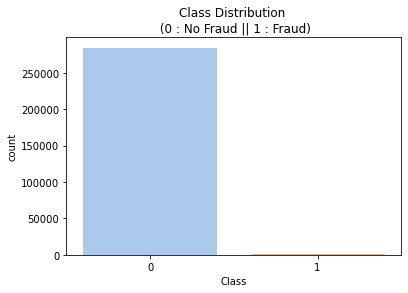

In [7]:
sns.countplot('Class', data = df, palette = 'pastel')
plt.title('Class Distribution \n (0 : No Fraud || 1 : Fraud)', size = 12)
plt.show()

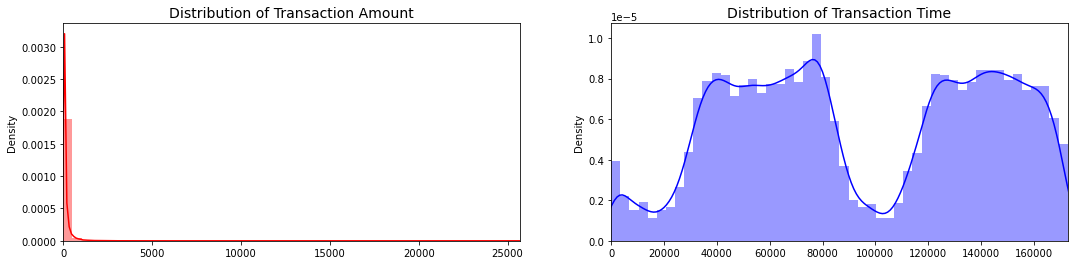

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax = ax[0], color = 'r')
ax[0].set_title('Distribution of Transaction Amount', fontsize= 14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax = ax[1], color = 'b')
ax[1].set_title('Distribution of Transaction Time', fontsize = 14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

<b> Sub-Sample

Fraud와 Non-Fraud의 50:50의 구성비를 가진 Sub-Sample을 만들어 줄 것이다. 

Q. 왜 Sub-sample을 만드나요?

A: Credit card 데이터가 상당히 불균형하다는 것을 확인했었다. 만약 이 데이터를 그대로 사용한다면 아래와 같은 문제가 발생한다.
    
   -  Overfitting
   -  Wrong Correlations : 우리가 'V'라는 feature가 어떤걸 나타내는지 모른다고 해도, target의 결과에 영향을 끼치는지 알 수는 있다. 하지만 불균형한 데이터셋에선 정확한 상관관계를 파악하기 힘들다.
   
   이를 해결하기 위해 Sub-sample을 생성해준다.

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler # Outlier에 덜 민감

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# scaling 해준 변수 생성
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis = 1, inplace = True)

In [10]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# 데이터프레임 앞쪽에 위치시키기 위한 작업
df.drop(['scaled_amount', 'scaled_time'], axis = 1, inplace = True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


<b> Splitting the Data(Original DataFrame) </b>

Random UnderSampling Techinique을 하기 전에, 원본 데이터프레임을 나눠줘야한다. 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('Non Frauds', round(df['Class'].value_counts()[0] / len(df) * 100, 2), '% of the Dataset')
print('Frauds', round(df['Class'].value_counts()[1] / len(df) * 100,2), '% of the Dataset')

X = df.drop('Class', axis = 1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state = None, shuffle = False)

for train_index, test_index in sss.split(X,y):
    print('Train: ', train_index, '\nTest: ' , test_index)
    original_Xtrain , original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    
# array 형식으로 바꿔줌
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts = True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts = True)
print('-' * 100)

print('Label Distribution: \n')
print(train_counts_label / len(original_ytrain))
print(test_counts_label / len(original_ytest))

Non Frauds 99.83 % of the Dataset
Frauds 0.17 % of the Dataset
Train:  [ 30473  30496  31002 ... 284804 284805 284806] 
Test:  [    0     1     2 ... 57017 57018 57019]
Train:  [     0      1      2 ... 284804 284805 284806] 
Test:  [ 30473  30496  31002 ... 113964 113965 113966]
Train:  [     0      1      2 ... 284804 284805 284806] 
Test:  [ 81609  82400  83053 ... 170946 170947 170948]
Train:  [     0      1      2 ... 284804 284805 284806] 
Test:  [150654 150660 150661 ... 227866 227867 227868]
Train:  [     0      1      2 ... 227866 227867 227868] 
Test:  [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distribution: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


### Random Under-Sampling

Overfitting을 피하기 위해 Random Under-Sampling(균형적인 데이터셋을 위해 데이터를 제거하는 Under-Sampling 기반)을 사용할 것이다.

<b> Step </b>
- 먼저 우리의 데이터가 얼마나 불균형적인지를 파악해야한다.
- Fraud transactions가 얼마나 있는지 파악했다면, Non-Fraud transaction을 Fraud Transaction 수에 맞춰준다. 이 데이터에서는 492개의 데이터가 Fraud기 때문에 Non-Fraud의 경우도 492개로 맞춰준다.
-위 과정이 끝나면, 우리는 50:50 비율의 Sub-Sample을 갖게 된다. 그 다음엔 데이터를 Shuffle 해서 모델이 일정 수준의 정확도를 유지할 수 있게 해준다.

In [12]:
df_copy = df.copy()

df = df.sample(frac = 1)

# Fraud는 492개.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac = 1, random_state = 42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
59616,-0.230699,-0.420247,-1.158167,1.363008,0.767806,-0.263684,0.125637,-0.495525,0.697985,0.100112,...,0.172868,0.069184,0.298155,-0.025180,0.204212,-0.359651,0.259904,0.271380,0.336174,0
12369,-0.293440,-0.740493,-18.018561,10.558600,-24.667741,11.786180,-10.564657,-2.645681,-18.023468,2.693655,...,1.007703,-2.319479,0.908839,1.352904,-1.059222,0.185751,0.687037,2.078081,-1.429517,1
137479,-0.272619,-0.029559,-0.272678,0.774899,2.236224,0.985357,0.129428,0.094583,0.369255,-0.085631,...,0.161492,0.047112,0.394567,-0.059886,0.083444,-0.570453,-0.442189,0.052258,-0.058997,0
249239,15.021170,0.817878,-0.082983,-3.935919,-2.616709,0.163310,-1.400952,-0.809419,1.501580,-0.471000,...,1.878612,0.702672,-0.182305,-0.921017,0.111635,-0.071622,-1.125881,-0.170947,0.126221,1
143333,-0.307413,0.006967,-7.030308,3.421991,-9.525072,5.270891,-4.024630,-2.865682,-6.989195,3.791551,...,0.545698,1.103398,-0.541855,0.036943,-0.355519,0.353634,1.042458,1.359516,-0.272188,1


## EDA

이제 우리의 데이터프레임이 꽤나 균형적인 분포를 띄고 있기 때문에 EDA와 전처리를 하자!

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


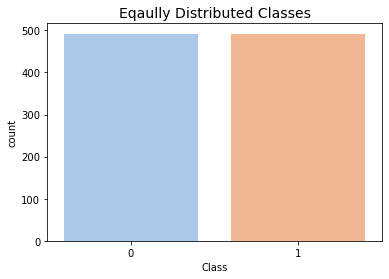

In [13]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts() / len(new_df))

sns.countplot('Class', data = new_df, palette = 'pastel')
plt.title('Eqaully Distributed Classes', fontsize = 14)
plt.show()

<b> Correlaton (상관계수)

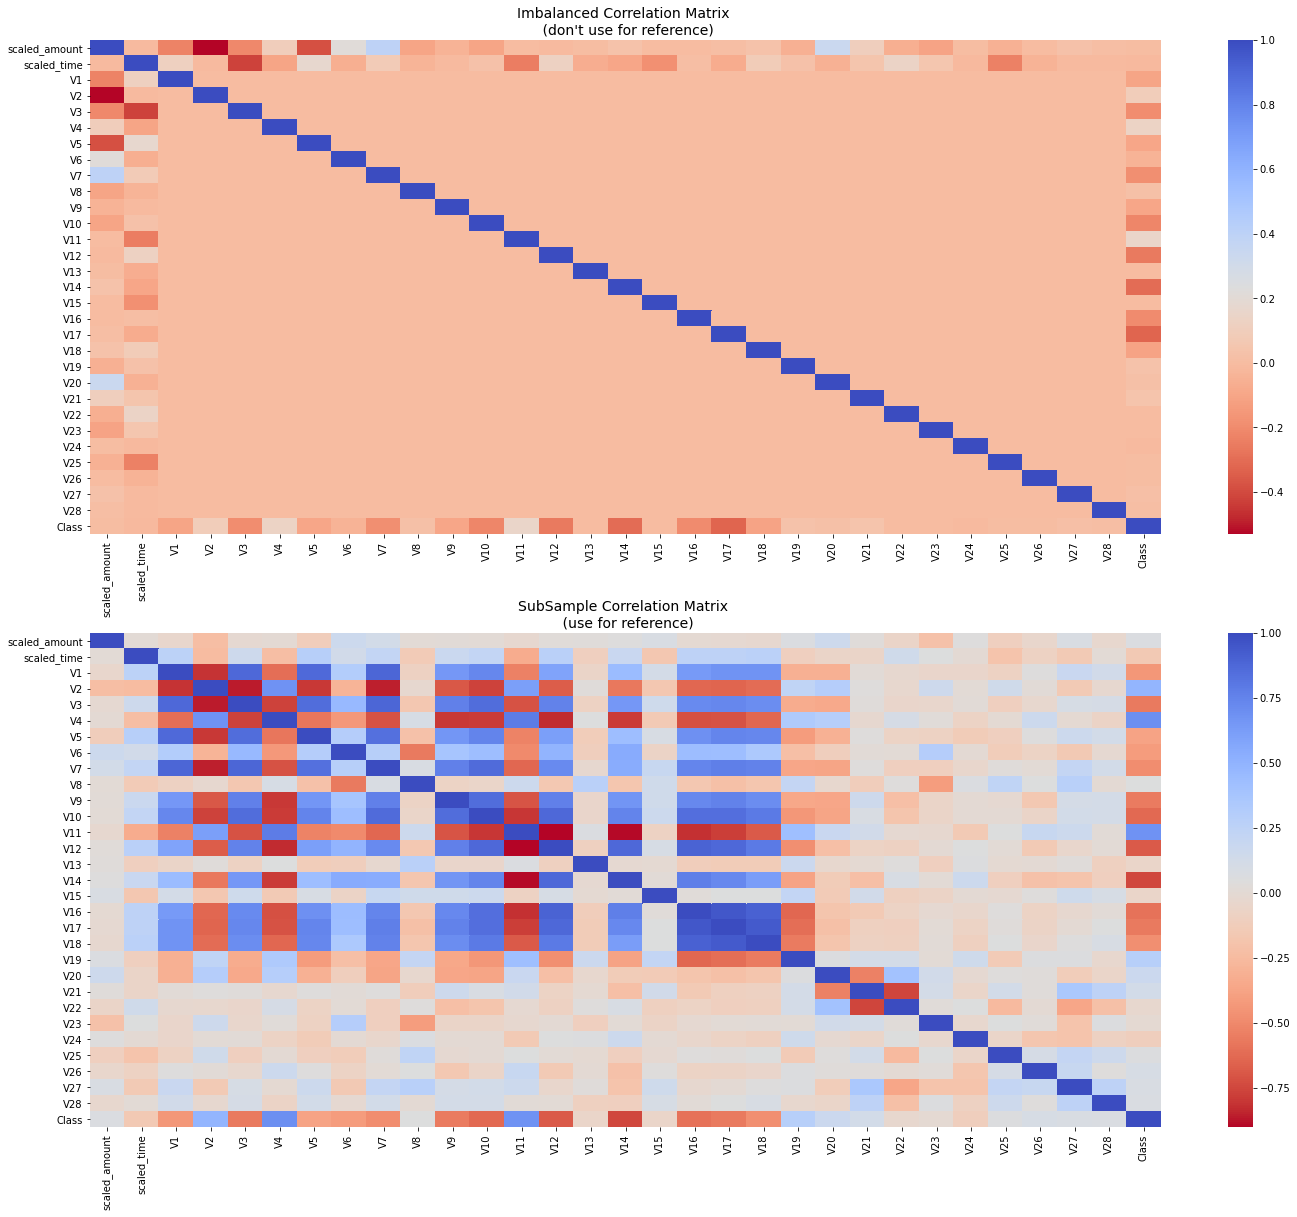

In [14]:
# 상관계수 행렬

f, (ax1, ax2) = plt.subplots(2, 1, figsize = (24,20))

# 원본 데이터(불균형)
corr = df.corr()
sns.heatmap(corr, cmap = 'coolwarm_r', annot_kws = {'size' : 20}, ax = ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize = 14)

# Sub-Sample(균형)
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap = 'coolwarm_r', annot_kws = {'size' : 20}, ax = ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize = 14)
plt.show()

확실히 차이가 난다.

In [15]:
# 양의 상관계수가 강한 변수들
print('Most Positive Correlations: \n', sub_sample_corr.sort_values('Class', ascending = False)['Class'][:10])

# 음의 상관계수가 약한 변수들
print('\nMost Negative Correlations: \n', sub_sample_corr.sort_values('Class', ascending = True)['Class'][:10])

Most Positive Correlations: 
 Class    1.000000
V4       0.701868
V11      0.685978
V2       0.490160
V19      0.291054
V20      0.169181
V21      0.126472
V26      0.093961
V27      0.085627
V28      0.075753
Name: Class, dtype: float64

Most Negative Correlations: 
 V14   -0.746480
V12   -0.680440
V10   -0.628138
V16   -0.592587
V3    -0.566182
V17   -0.559738
V9    -0.558560
V7    -0.479464
V18   -0.471615
V1    -0.434164
Name: Class, dtype: float64


쉽게 보기 위해 다른 커널에서 배운 테크닉을 사용해보았다.

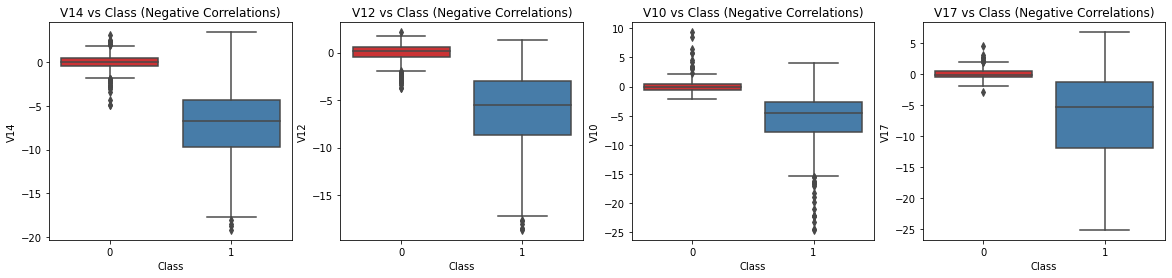

In [16]:
f, axes = plt.subplots(ncols = 4, figsize = (20,4))

# Negative Correlations
sns.boxplot(x = 'Class', y = 'V14', data = new_df, palette = 'Set1', ax = axes[0])
axes[0].set_title('V14 vs Class (Negative Correlations)')

sns.boxplot(x = 'Class', y = 'V12', data = new_df, palette = 'Set1',  ax = axes[1])
axes[1].set_title('V12 vs Class (Negative Correlations)')

sns.boxplot(x = 'Class', y = 'V10', data = new_df, palette = 'Set1', ax = axes[2])
axes[2].set_title('V10 vs Class (Negative Correlations)')

sns.boxplot(x = 'Class', y = 'V17', data = new_df, palette = 'Set1', ax = axes[3])
axes[3].set_title('V17 vs Class (Negative Correlations)')
plt.show()

커널 작성자인 Janio Martinez Bachmann은 V16 대신 V17을 그렸다. 

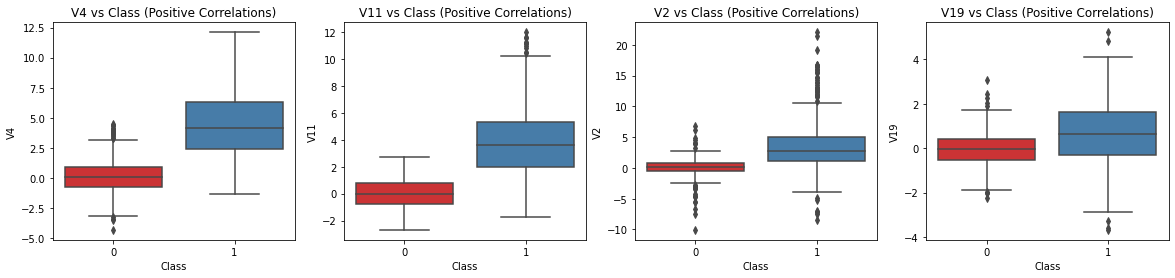

In [17]:
f, axes = plt.subplots(ncols = 4, figsize = (20,4))

# Positive Correlations
sns.boxplot(x = 'Class', y = 'V4', data = new_df, palette = 'Set1', ax = axes[0])
axes[0].set_title('V4 vs Class (Positive Correlations)')

sns.boxplot(x = 'Class', y = 'V11', data = new_df, palette = 'Set1',  ax = axes[1])
axes[1].set_title('V11 vs Class (Positive Correlations)')

sns.boxplot(x = 'Class', y = 'V2', data = new_df, palette = 'Set1', ax = axes[2])
axes[2].set_title('V2 vs Class (Positive Correlations)')

sns.boxplot(x = 'Class', y = 'V19', data = new_df, palette = 'Set1', ax = axes[3])
axes[3].set_title('V19 vs Class (Positive Correlations)')
plt.show()

<b> Anomaly Detection 이상치 탐색 </b>

강한 상관관계를 가진 변수 중에서 extreme outlier들을 제거한다. 이는 모델의 정확도를 올려줄 것이다.

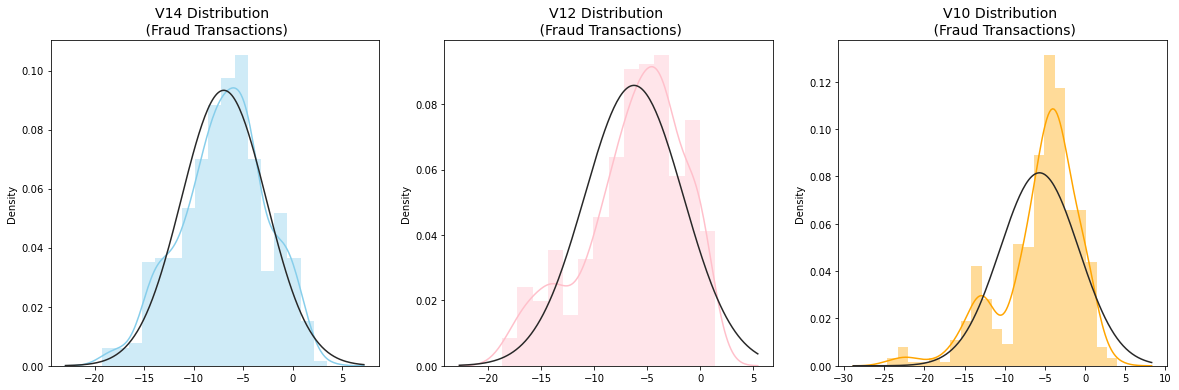

In [18]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax = ax1, fit = norm, color = 'skyblue')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize = 14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax = ax2, fit = norm, color = 'pink')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize = 14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax = ax3, fit = norm, color = 'orange')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize = 14)
plt.show()

In [19]:
# V14 removing Outliers
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quantile 25: {} | Quantile 75 : {}'.format(q25, q75))
v14_iqr = q75 - q25

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off : {}'.format(v14_cut_off))
print('V14 Lower : {}'.format(v14_lower))
print('V14 Upper : {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases : {}'.format(len(outliers)))
print('V14 Outliers: {}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('-' * 44)

# V12 removing Outliers
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Quantile 25: {} | Quantile 75 : {}'.format(q25, q75))
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Cut Off : {}'.format(v12_cut_off))
print('V12 Lower : {}'.format(v12_lower))
print('V12 Upper : {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Feature V12 Outliers for Fraud Cases : {}'.format(len(outliers)))
print('V12 Outliers: {}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('-' * 44)

# V10 Removing Outliers
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('Quantile 25: {} | Quantile 75 : {}'.format(q25, q75))
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('Cut Off : {}'.format(v10_cut_off))
print('V10 Lower : {}'.format(v10_lower))
print('V10 Upper : {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Feature V10 Outliers for Fraud Cases : {}'.format(len(outliers)))
print('V10 Outliers: {}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('-' * 44)

Quantile 25: -9.692722964972385 | Quantile 75 : -4.282820849486866
Cut Off : 8.114853173228278
V14 Lower : -17.807576138200663
V14 Upper : 3.8320323237414122
Feature V14 Outliers for Fraud Cases : 4
V14 Outliers: [-18.049997689859396, -19.2143254902614, -18.8220867423816, -18.4937733551053]
--------------------------------------------
Quantile 25: -8.67303320439115 | Quantile 75 : -2.893030568676315
Cut Off : 8.670003953572252
V12 Lower : -17.3430371579634
V12 Upper : 5.776973384895937
Feature V12 Outliers for Fraud Cases : 4
V12 Outliers: [-18.4311310279993, -18.047596570821604, -18.553697009645802, -18.683714633344298]
--------------------------------------------
Quantile 25: -7.466658535821848 | Quantile 75 : -2.5118611381562523
Cut Off : 7.4321960964983935
V10 Lower : -14.89885463232024
V10 Upper : 4.920334958342141
Feature V10 Outliers for Fraud Cases : 27
V10 Outliers: [-22.1870885620007, -15.124162814494698, -16.6496281595399, -24.5882624372475, -18.9132433348732, -16.2556117491

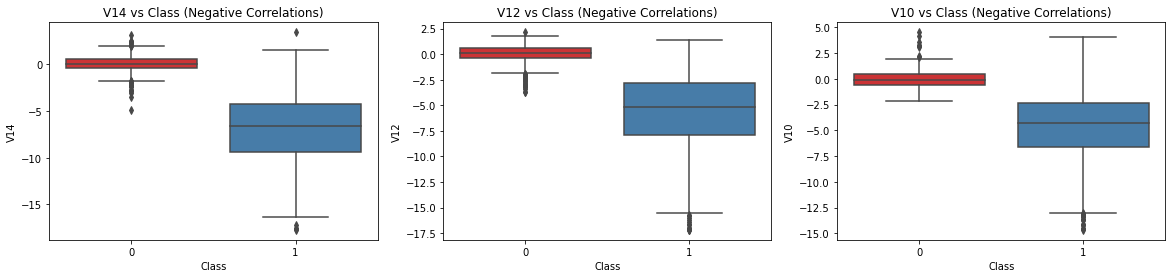

In [20]:
f, axes = plt.subplots(ncols = 3, figsize = (20,4))

sns.boxplot(x = 'Class', y = 'V14', data = new_df, palette = 'Set1', ax = axes[0])
axes[0].set_title('V14 vs Class (Negative Correlations)')

sns.boxplot(x = 'Class', y = 'V12', data = new_df, palette = 'Set1',  ax = axes[1])
axes[1].set_title('V12 vs Class (Negative Correlations)')

sns.boxplot(x = 'Class', y = 'V10', data = new_df, palette = 'Set1', ax = axes[2])
axes[2].set_title('V10 vs Class (Negative Correlations)')
plt.show()

### Dimensionality Reduction and Clustering

t-SNE : https://lovit.github.io/nlp/representation/2018/09/28/tsne/

In [21]:
X = new_df.drop('Class', axis = 1)
y = new_df['Class']

# t-SNE 
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state = 42).fit_transform(X.values)
t1 = time.time()
print('T-SNE took {:.2} s'.format(t1 - t0))

# PCA
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state = 42).fit_transform(X.values)
t1 = time.time()
print('PCA took {:.2} s'.format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state = 42).fit_transform(X.values)
t1= time.time()
print('Truncated SVD took {:.2} s'.format(t1-t0))

T-SNE took 3.0 s
PCA took 0.022 s
Truncated SVD took 0.003 s


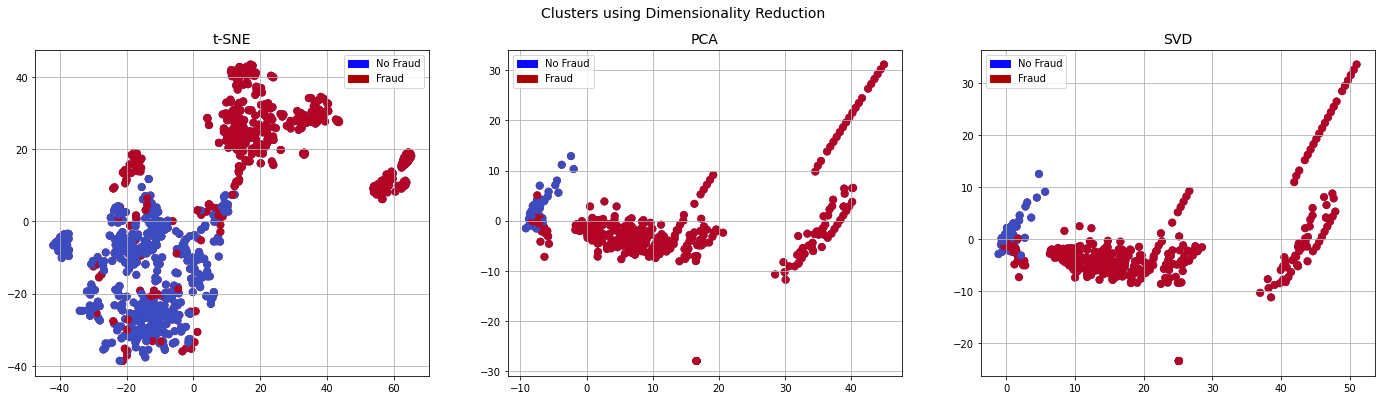

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24,6))

f.suptitle('Clusters using Dimensionality Reduction', fontsize =14)

blue_patch = mpatches.Patch(color = '#0A0AFF', label = 'No Fraud')
red_patch = mpatches.Patch(color = '#AF0000', label = 'Fraud')

# t-SNE 
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c = (y==0), cmap = 'coolwarm', label = 'No Fraud', linewidths = 2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c = (y==1), cmap = 'coolwarm', label = 'Fraud', linewidths = 2)
ax1.set_title('t-SNE', fontsize = 14)
ax1.grid(True)
ax1.legend(handles = [blue_patch, red_patch])

# PCA 
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c = (y==0), cmap = 'coolwarm', label = 'No Fraud', linewidths = 2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c = (y==1), cmap = 'coolwarm', label = 'Fraud', linewidths = 2)
ax2.set_title('PCA', fontsize = 14)
ax2.grid(True)
ax2.legend(handles = [blue_patch, red_patch])

# TruncatedSVD
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c = (y==0), cmap = 'coolwarm', label = 'No Fraud', linewidths = 2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c = (y==1), cmap = 'coolwarm', label = 'Fraud', linewidths = 2)
ax3.set_title('SVD', fontsize = 14)
ax3.grid(True)
ax3.legend(handles = [blue_patch, red_patch])

plt.show()

## Classifiers (Undersampling):

이번 장에서는 4가지 타입의 분류기를 학습하고, 어떤 분류기가 fraud transactions를 잘 찾아내는지 판단할 것이다. 그전에 train과 test셋을 나눠줘야한다.

In [37]:
# features와 target 지정
X = new_df.drop('Class', axis =1)
y = new_df['Class']

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 2, random_state = 42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_Test = y_test.values

In [40]:
classifiers = {
    'LogisticRegression' : LogisticRegression(),
    'KNearst' : KNeighborsClassifier(),
    'Support Vecor Classifier' : SVC(),
    'Decision Tree Classifier' : DecisionTreeClassifier()
}

In [42]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv = 5)
    print('Classifier: ', classifier.__class__.__name__, 'Has a traing score of', round(training_score.mean(), 2) * 100, '% accuracy score')

Classifier:  LogisticRegression Has a traing score of 94.0 % accuracy score
Classifier:  KNeighborsClassifier Has a traing score of 94.0 % accuracy score
Classifier:  SVC Has a traing score of 93.0 % accuracy score
Classifier:  DecisionTreeClassifier Has a traing score of 90.0 % accuracy score


<b> GridSearch CV

In [47]:
from sklearn.model_selection import GridSearchCV

# 로지스틱 회귀
log_reg_params = {'penalty' : ['l1', 'l2', 'l3'], 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

# KNN
knear_params = {'n_neighbors' : list(range(2,5,1)), 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knear_params)
grid_knears.fit(X_train, y_train)
knear_neighbors = grid_knears.best_estimator_

# 서포트 벡터머신
svc_params = {'C' : [0.5, 0.7, 0.9, 1], 'kernel' : ['rbf', 'poly', 'sigmoid', 'linear']}
grid_scv = GridSearchCV(SVC(), svc_params)
grid_scv.fit(X_train, y_train)
svc = grid_scv.best_estimator_

# 의사결정트리
tree_params = {'criterion' : ['gini', 'entropy'], 'max_depth' : list(range(2,4,1)), 'min_samples_leaf': list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [49]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv = 5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100 , 2).astype(str) + '%')

knears_score = cross_val_score(knear_neighbors, X_train, y_train, cv =5)
print('Knears Neighbors Cross Validation Score: ', round(knears_score.mean() * 100 , 2).astype(str) +  '%')

svc_score = cross_val_score(svc, X_train, y_train, cv = 5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100 , 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv = 5)
print('Decision Tree Classifier Cross Validation Score', round(tree_score.mean() * 100 ,2).astype(str) + '%'')

SyntaxError: EOL while scanning string literal (<ipython-input-49-64e6e32c6f29>, line 11)